# Artificial Intelligence Nanodegree
## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

In [15]:
import collections

import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization

def catAcc(m,x,y):
    print("Train accurancy: ", m.evaluate(x, y, verbose=0)[1])

def catHistory(his):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(his.epoch, his.history["loss"], label="Train loss")
    ax_loss.plot(his.epoch, his.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(his.epoch, his.history["acc"], label="Train score")
    ax_score.plot(his.epoch, his.history["val_acc"], label="Validation score")
    ax_score.legend()

### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4155485099448991088
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 357302272
locality {
  bus_id: 1
}
incarnation: 12393585368006079585
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [5]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [6]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [7]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [8]:
def tokenize(x):
    tkz = Tokenizer()
    tkz.fit_on_texts(x)
    return tkz.texts_to_sequences(x), tkz

tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [9]:
def pad(x, length=None):
    return pad_sequences(x,padding='post') if length==None else pad_sequences(x, maxlen=length,padding='post')

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [10]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [11]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [22]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    lr: learning rate
    il: input layer
    gl: GRU layer
    td: TimeDistributed wrapper
    m: model
    """
    lr = 1e-3
    il = Input(input_shape[1:])
    gl = GRU(64, return_sequences=True)(il)
    td = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(gl)
    
    m = Model(inputs=il, outputs=td)
    m.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(lr),
                  metrics=['accuracy'])
    
    return m

tests.test_simple_model(simple_model)

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

sm = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

# es = EarlyStopping(monitor='val_loss', patience=3)
# h = sm.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.4, callbacks=[es])

es = EarlyStopping(monitor='val_acc', patience=3)
tb = TensorBoard(log_dir='./logs/sm', histogram_freq=0, write_graph=True, write_images=True)
h = sm.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2, callbacks=[tb,es])

print(logits_to_text(sm.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 7s 60us/step - loss: 3.4440 - acc: 0.4124 - val_loss: nan - val_acc: 0.4556
Epoch 2/10
110288/110288 [==============================] - 6s 58us/step - loss: 2.4181 - acc: 0.4729 - val_loss: nan - val_acc: 0.4888
Epoch 3/10
110288/110288 [==============================] - 6s 58us/step - loss: 2.1651 - acc: 0.5122 - val_loss: nan - val_acc: 0.5332
Epoch 4/10
110288/110288 [==============================] - 6s 58us/step - loss: 1.9469 - acc: 0.5470 - val_loss: nan - val_acc: 0.5717
Epoch 5/10
110288/110288 [==============================] - 6s 58us/step - loss: 1.7989 - acc: 0.5761 - val_loss: nan - val_acc: 0.5837
Epoch 6/10
110288/110288 [==============================] - 6s 58us/step - loss: 1.6936 - acc: 0.5838 - val_loss: nan - val_acc: 0.5904
Epoch 7/10
110288/110288 [==============================] - 6s 58us/step - loss: 1.6177 - acc: 0.5916 - val_loss: nan - val_acc: 0.59

Train accurancy:  0.614475067178


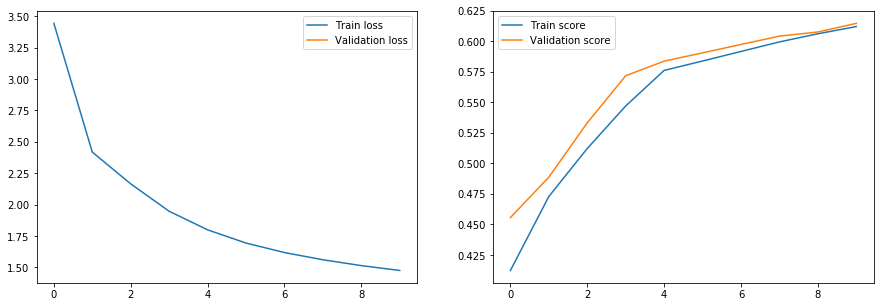

In [23]:
catAcc(sm, tmp_x, preproc_french_sentences)
catHistory(h)

### Model 2: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [24]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    lr: learning rate
    il: input layer
    el: embedding layer
    gl: GRU layer
    td: TimeDistributed wrapper
    m: model
    """
    lr = 1e-3
    il = Input(input_shape[1:])
    el = Embedding(english_vocab_size, 64, input_length=output_sequence_length)(il)
    gl = GRU(64, return_sequences=True)(el)
    td = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(gl)
    
    m = Model(inputs=il, outputs=td)
    m.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(lr),
                  metrics=['accuracy'])
    
    return m

tests.test_embed_model(embed_model)

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)

# TODO: Train the neural network
em = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

es = EarlyStopping(monitor='val_acc', patience=3)
tb = TensorBoard(log_dir='./logs/em', write_graph=True, write_images=True)

h = em.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2, callbacks=[tb,es])

# TODO: Print prediction(s)
print(logits_to_text(em.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 7s 68us/step - loss: 3.8167 - acc: 0.4002 - val_loss: nan - val_acc: 0.4093
Epoch 2/10
110288/110288 [==============================] - 7s 66us/step - loss: 2.7439 - acc: 0.4310 - val_loss: nan - val_acc: 0.5122
Epoch 3/10
110288/110288 [==============================] - 7s 66us/step - loss: 2.0056 - acc: 0.5561 - val_loss: nan - val_acc: 0.6090
Epoch 4/10
110288/110288 [==============================] - 7s 66us/step - loss: 1.4384 - acc: 0.6532 - val_loss: nan - val_acc: 0.6930
Epoch 5/10
110288/110288 [==============================] - 7s 66us/step - loss: 1.1364 - acc: 0.7211 - val_loss: nan - val_acc: 0.7463
Epoch 6/10
110288/110288 [==============================] - 7s 66us/step - loss: 0.9485 - acc: 0.7608 - val_loss: nan - val_acc: 0.7741
Epoch 7/10
110288/110288 [==============================] - 7s 66us/step - loss: 0.8204 - acc: 0.7849 - val_loss: nan - val_acc: 0.79

Train accurancy:  0.837841537391


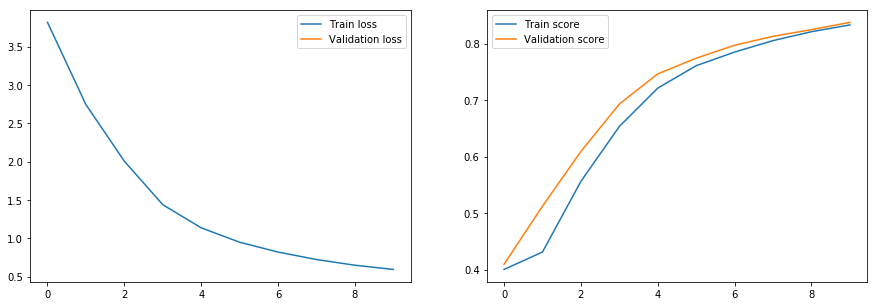

In [25]:
catAcc(em, tmp_x, preproc_french_sentences)
catHistory(h)

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [27]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    lr: learning rate
    il: input layer
    gl: GRU layer
    bd: Bidirectional wrapper
    td: TimeDistributed wrapper
    m: model
    """
    lr = 1e-3
    il = Input(input_shape[1:])
    gl = GRU(64, return_sequences=True)
    bd = Bidirectional(gl)(il)
    td = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(bd)
    
    m = Model(inputs=il, outputs=td)
    m.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(lr),
                  metrics=['accuracy'])
    
    return m

tests.test_bd_model(bd_model)


# TODO: Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

bm = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

es = EarlyStopping(monitor='val_acc', patience=3)
tb = TensorBoard(log_dir='./logs/bm', write_graph=True, write_images=True)

h = bm.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2, callbacks=[tb,es])

print(logits_to_text(bm.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 10s 92us/step - loss: 3.1771 - acc: 0.4646 - val_loss: nan - val_acc: 0.5312
Epoch 2/10
110288/110288 [==============================] - 10s 90us/step - loss: 1.9155 - acc: 0.5560 - val_loss: nan - val_acc: 0.5756
Epoch 3/10
110288/110288 [==============================] - 10s 90us/step - loss: 1.6101 - acc: 0.5911 - val_loss: nan - val_acc: 0.6085
Epoch 4/10
110288/110288 [==============================] - 10s 90us/step - loss: 1.4686 - acc: 0.6155 - val_loss: nan - val_acc: 0.6227
Epoch 5/10
110288/110288 [==============================] - 10s 90us/step - loss: 1.3858 - acc: 0.6296 - val_loss: nan - val_acc: 0.6372
Epoch 6/10
110288/110288 [==============================] - 10s 89us/step - loss: 1.3251 - acc: 0.6378 - val_loss: nan - val_acc: 0.6418
Epoch 7/10
110288/110288 [==============================] - 10s 90us/step - loss: 1.2738 - acc: 0.6467 - val_loss: nan - val_ac

Train accurancy:  0.668185830371


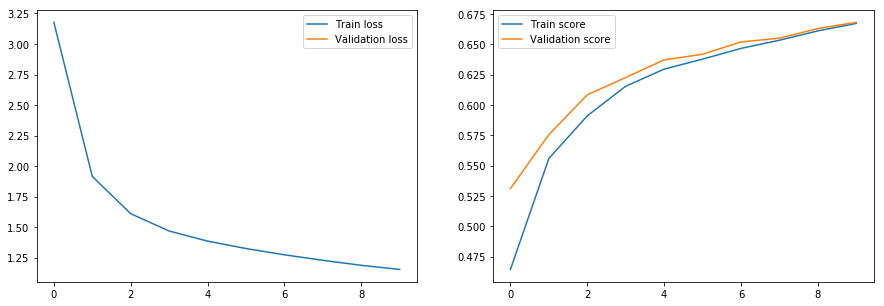

In [28]:
catAcc(bm, tmp_x, preproc_french_sentences)
catHistory(h)

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [29]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    from keras.layers import LSTM
    
    lr = 1e-3
    
    il = Input(input_shape[1:])
    encode_lstm = LSTM(64)(il)
    rv = RepeatVector(output_sequence_length)(encode_lstm)
    decode_lstm = LSTM(64, return_sequences=True)(rv)
    td = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(decode_lstm)

    model = Model(inputs=il, outputs=td)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(lr),
                  metrics=['accuracy'])

    return model

tests.test_encdec_model(encdec_model)


# OPTIONAL: Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))


ecdcm = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

tb = TensorBoard(log_dir='./logs/ecdcm', write_graph=True, write_images=True)

es = EarlyStopping(monitor='val_acc', patience=3)
h = ecdcm.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2, callbacks = [tb,es])

# TODO: Print prediction(s)
print(logits_to_text(ecdcm.predict(tmp_x[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 13s 117us/step - loss: 3.5055 - acc: 0.4056 - val_loss: nan - val_acc: 0.4444
Epoch 2/10
110288/110288 [==============================] - 13s 114us/step - loss: 2.5636 - acc: 0.4694 - val_loss: nan - val_acc: 0.4954
Epoch 3/10
110288/110288 [==============================] - 13s 114us/step - loss: 2.3060 - acc: 0.4971 - val_loss: nan - val_acc: 0.5002
Epoch 4/10
110288/110288 [==============================] - 13s 114us/step - loss: 2.0931 - acc: 0.5083 - val_loss: nan - val_acc: 0.5146
Epoch 5/10
110288/110288 [==============================] - 13s 114us/step - loss: 1.9527 - acc: 0.5268 - val_loss: nan - val_acc: 0.5338
Epoch 6/10
110288/110288 [==============================] - 13s 113us/step - loss: 1.8645 - acc: 0.5417 - val_loss: nan - val_acc: 0.5500
Epoch 7/10
110288/110288 [==============================] - 13s 114us/step - loss: 1.7914 - acc: 0.5534 - val_loss: nan -

Train accurancy:  0.580209356679


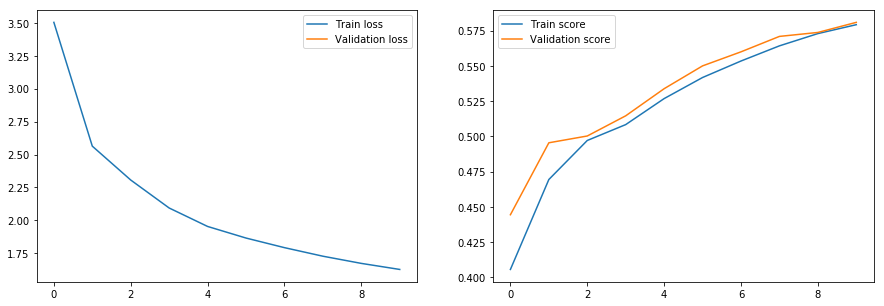

In [30]:
catAcc(ecdcm, tmp_x, preproc_french_sentences)
catHistory(h)

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [31]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    lr=1e-3
    il = Input(input_shape[1:])
    el = Embedding(english_vocab_size, 64, input_length=output_sequence_length)(il)
    bd = Bidirectional(GRU(64, return_sequences=True))(el)
    td = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(bd)

    m = Model(inputs=il, outputs=td)
    m.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(lr),
                  metrics=['accuracy'])
    
    return m

tests.test_model_final(model_final)


print('Final Model Loaded')

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)

fm = model_final(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

es = EarlyStopping(monitor='val_acc', patience=3)
tb = TensorBoard(log_dir='./logs/fm', write_graph=True, write_images=True)

fm.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2, callbacks=[tb,es])

# Print prediction(s)
print(logits_to_text(fm.predict(tmp_x[:1])[0], french_tokenizer))

Final Model Loaded
Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 12s 107us/step - loss: 3.4543 - acc: 0.4284 - val_loss: nan - val_acc: 0.4755
Epoch 2/10
110288/110288 [==============================] - 12s 105us/step - loss: 2.3461 - acc: 0.4967 - val_loss: nan - val_acc: 0.5415
Epoch 3/10
110288/110288 [==============================] - 12s 104us/step - loss: 1.6363 - acc: 0.6097 - val_loss: nan - val_acc: 0.6559
Epoch 4/10
110288/110288 [==============================] - 12s 106us/step - loss: 1.1843 - acc: 0.7009 - val_loss: nan - val_acc: 0.7357
Epoch 5/10
110288/110288 [==============================] - 12s 106us/step - loss: 0.9339 - acc: 0.7557 - val_loss: nan - val_acc: 0.7736
Epoch 6/10
110288/110288 [==============================] - 12s 105us/step - loss: 0.7789 - acc: 0.7884 - val_loss: nan - val_acc: 0.8032
Epoch 7/10
110288/110288 [==============================] - 12s 104us/step - loss: 0.6648 - acc: 0.813

Train accurancy:  0.866583392353


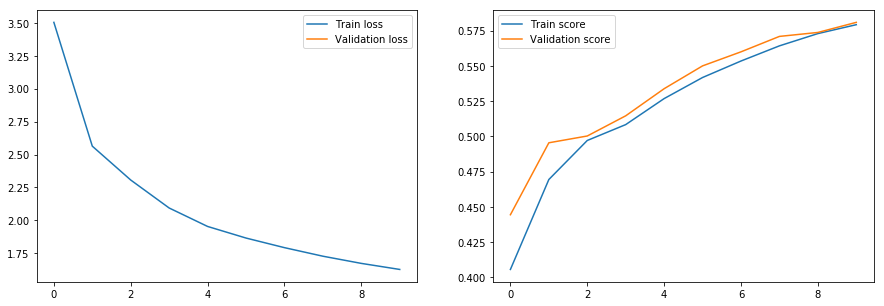

In [32]:
catAcc(fm, tmp_x, preproc_french_sentences)
catHistory(h)

## Prediction (IMPLEMENTATION)

In [40]:
def final_predictions(x, y, x_tk, y_tk):

    max_english_sequence_length = x.shape[1]
    max_french_sequence_length = y.shape[1]
    english_vocab_size = len(x_tk.word_index)
    french_vocab_size = len(y_tk.word_index)

    x = pad(x, max_french_sequence_length)

    es = EarlyStopping(monitor='val_acc', patience=10)
    tb = TensorBoard(log_dir='./logs/fmp', write_graph=True, write_images=True)
    rlr = ReduceLROnPlateau(monitor='val_acc', patience=2, min_lr=1e-9)
    
    model = model_final(x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)
    
    h = model.fit(x, y, batch_size=1024, epochs=100, validation_split=0.25, callbacks=[rlr,es,tb])

    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))
    
    return h, model


h, m = final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

Train on 103395 samples, validate on 34466 samples
Epoch 1/100
103395/103395 [==============================] - 12s 112us/step - loss: 3.5340 - acc: 0.4196 - val_loss: nan - val_acc: 0.4735
Epoch 2/100
103395/103395 [==============================] - 11s 107us/step - loss: 2.3461 - acc: 0.4999 - val_loss: nan - val_acc: 0.5416
Epoch 3/100
103395/103395 [==============================] - 11s 107us/step - loss: 1.6527 - acc: 0.6074 - val_loss: nan - val_acc: 0.6505
Epoch 4/100
103395/103395 [==============================] - 11s 107us/step - loss: 1.2560 - acc: 0.6806 - val_loss: nan - val_acc: 0.7108
Epoch 5/100
103395/103395 [==============================] - 11s 107us/step - loss: 1.0135 - acc: 0.7316 - val_loss: nan - val_acc: 0.7537
Epoch 6/100
103395/103395 [==============================] - 11s 107us/step - loss: 0.8398 - acc: 0.7693 - val_loss: nan - val_acc: 0.7838
Epoch 7/100
103395/103395 [==============================] - 11s 107us/step - loss: 0.7171 - acc: 0.7968 - val_loss

Train accurancy:  0.979458610623


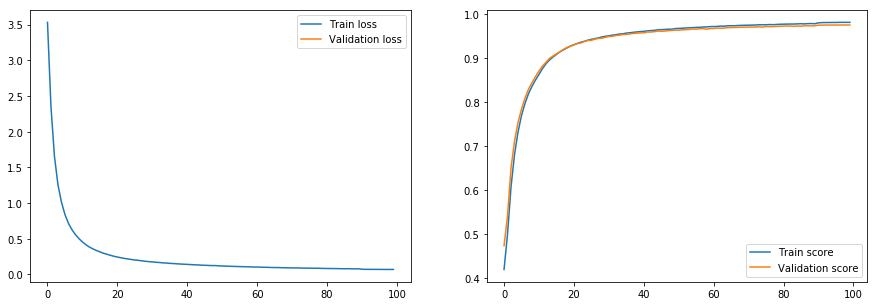

In [41]:
catAcc(m, tmp_x, preproc_french_sentences)
catHistory(h)

## Submission
When you're ready to submit, complete the following steps:
1. Review the [rubric](https://review.udacity.com/#!/rubrics/1004/view) to ensure your submission meets all requirements to pass
2. Generate an HTML version of this notebook

  - Run the next cell to attempt automatic generation (this is the recommended method in Workspaces)
  - Navigate to **FILE -> Download as -> HTML (.html)**
  - Manually generate a copy using `nbconvert` from your shell terminal
```
$ pip install nbconvert
$ python -m nbconvert machine_translation.ipynb
```
  
3. Submit the project

  - If you are in a Workspace, simply click the "Submit Project" button (bottom towards the right)
  
  - Otherwise, add the following files into a zip archive and submit them 
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.

### Generate the html

**Save your notebook before running the next cell to generate the HTML output.** Then submit your project.

In [ ]:
# Save before you run this cell!
!!jupyter nbconvert *.ipynb

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?